# Proyecto de la materia Procesamiento Embebido de Señales
## Segmentación de imágenes con OpenCV y SciKit-image
### Métodos de sementación de imágenes

![alt text](metodos_segmentacion.png "Metodos Segmentación")

El presente trabajo práctico tiene como objetivo la segmentación **no supervisada** de imagenes.

Para ello se cuentan con las siguientes etapas:
1. Preprocesamiento de la imagen
2. Visualización del histograma de la imagen (en RGB)
3. Algoritmo K-Means (OpenCV)
4. Algoritmo SLIC (Simple Linear Iterative Clustering)
    1. RAG con corte por umbral
    2. RAG con corte normalizado
    3. RAG con Merge
5. Algoritmo Felzenszwalb
    1. RAG con corte por umbral
    2. RAG con corte normalizado
    3. RAG con Merge
6. Contadores de segmentos únicos segun cada algoritmo con su variante
7. Histograma de gradientes orientados
8. Etiquetado de contornos en base a segmentación realizada (Labeling)

Finalmente se comparará el algoritmo con una imagen ruidosa:
1. Agregación de ruido a la imagen original

Pendientes a implementar:
1. Hierarchical Merging of Region Boundary RAGs
2. Drawing Region Adjacency Graphs (RAGs)
3. Morphological Snakes
4. Entropía



### Algoritmo K-Means
Se caracteriza por buscar los centros de una cierta cantidad de clusters y agrupa las muestras de entrada en dichos clusters.

### Algoritmo SLIC (Simple Linear Iterative Clustering)
Se caracteriza por utilizar otro algoritmo de machine-learning denominado K-Means.
El mismo toma todos los valores de los pixeles de la imagen e intenta separarlos en una determinada cantidad de sub-regiones.
Toma la imagen a color (3 canales) por lo que se usará la imagen original

### Algoritmo Felzenszwalb


Nota: al método utilizado para segmentar se lo conoce como "over-segmentation" ya que corresponde a una primera aproximación de segmentación en un algoritmo real.

### RAG Thresholding
La técnica Region Adjacency Graph (RAG) realiza un merge de las regiones que tienen colores similares. Se construirá un RAG y se definirán bordes como la diferencia del promedio de colores. Luego se unirán las regiones que contengan un promedio de color similar (dependiendo el umbral de threshold).

## Fotos testeadas y funcionando
- Ver en tabla de relevamiento: [tabla](https://docs.google.com/spreadsheets/d/1Ey8KQBl52hk2BRXCLVf9PqZZdgr6qZLkrs4R8OZtqFc/edit)

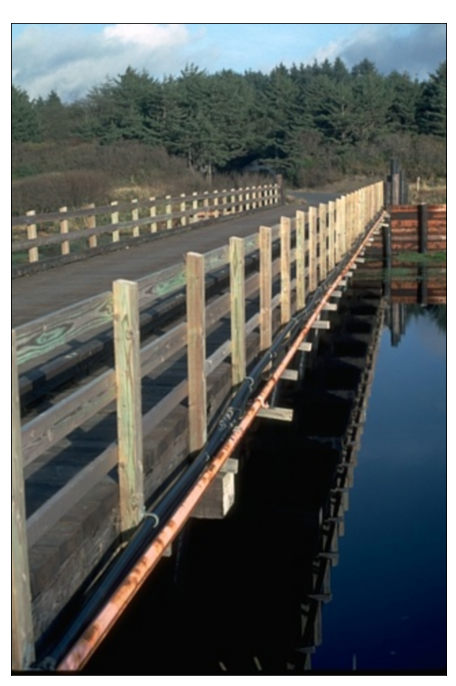

In [2]:
from __future__ import division
import cv2
import numpy as np
import scipy
import matplotlib.pyplot as plt
import imutils
import skimage.data as data
import skimage.exposure as exposure
import skimage.segmentation as seg
import skimage.filters as filters
import skimage.draw as draw
import skimage.color as color
import skimage.feature as feature
import skimage.morphology as morph
import skimage.util as util
import skimage.future as future

def nothing(x):
    pass

# parametros de ajuste
invertir_threshold = True
umbral = 100
kernel_apertura = (3,3)
iter_apertura = 4
kernel_cierre = (3,3)
iter_cierre = 5

# Importar imagen del dataset
ruta_img = 'imagenes/22013.jpg'
imagen = cv2.imread(ruta_img,1)
# Se transforma la imagen BRG a HSV
imagen = cv2.cvtColor(imagen, cv2.cv.CV_BGR2HSV)


fig = plt.figure(figsize=(18,12))
plt.title("Imagen: {}".format(ruta_img.split('/')[-1]),color="white")
plt.xticks([]),plt.yticks([])
# Se grafica la imagen con MATPLOTLIB
imagen_rgb = cv2.cvtColor(imagen, cv2.COLOR_HSV2RGB)
plt.imshow(imagen_rgb, interpolation = 'bicubic')

plt.show()

### Agregación de ruido a la imagen

Text(0.5,1,'Imagen 22013.jpg con el ruido agregado')

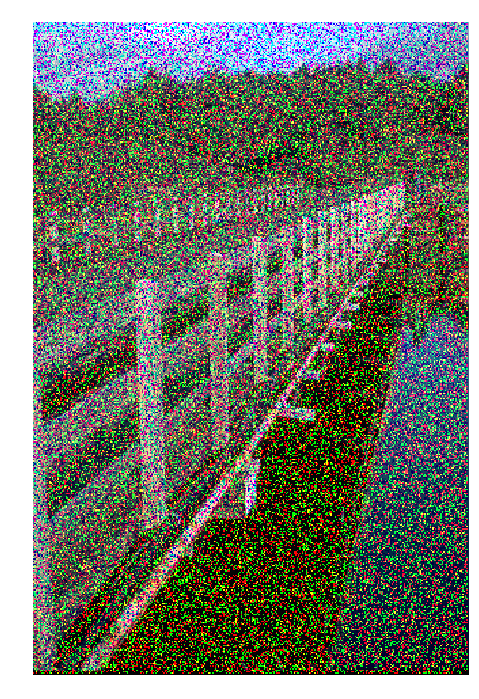

In [3]:
img_ruidosa_rgb = np.copy(imagen_rgb)
coords = [np.random.randint(0, i - 1, 100000)
              for i in imagen.shape]
img_ruidosa_rgb[tuple(coords)] = 255
coords = [np.random.randint(0, i - 1, 100000)
              for i in imagen.shape]
img_ruidosa_rgb[tuple(coords)] = 0
#img_ruidosa_rgb = cv2.cvtColor(img_ruidosa, cv2.COLOR_HSV2RGB)
fig = plt.figure(figsize=(18,12))
plt.imshow(img_ruidosa_rgb)
plt.axis('off')
plt.title('Imagen {} con el ruido agregado'.format(ruta_img.split('/')[-1]),
          color="white")


Text(0.5,1,'Imagen 22013.jpg con el ruido subsanado')

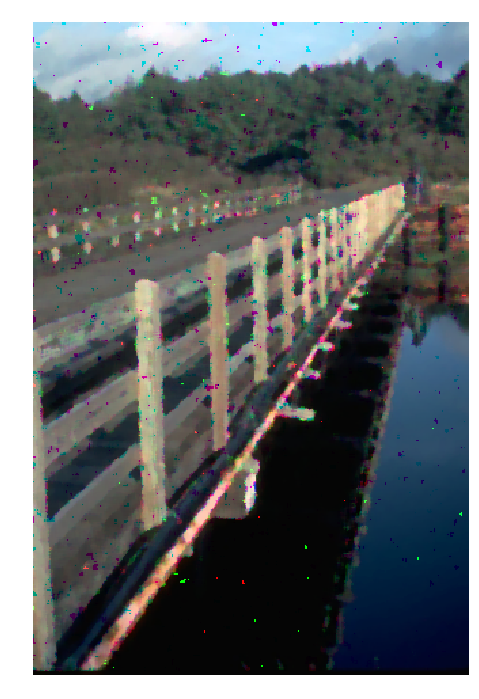

In [4]:
mediana = cv2.medianBlur(img_ruidosa_rgb,5)
fig = plt.figure(figsize=(18,12))
plt.imshow(mediana)
plt.axis('off')
plt.title('Imagen {} con el ruido subsanado'.format(ruta_img.split('/')[-1]),
          color="white")


### Preprocesamiento de la imagen

Text(0.5,1,'Imagen 22013.jpg filtrada por mediana')

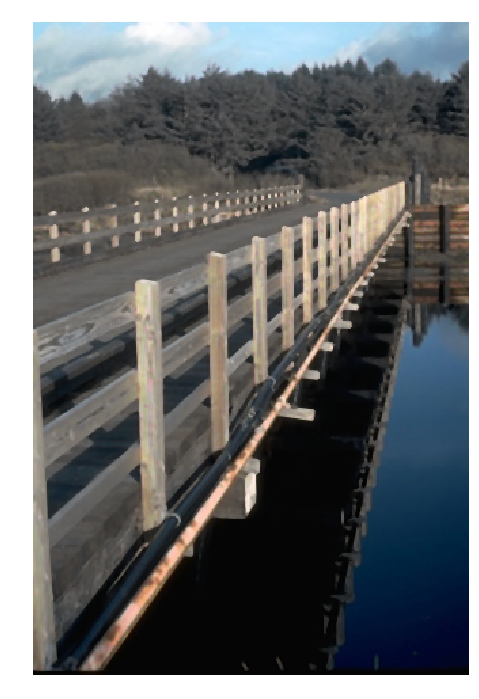

In [5]:
# Se aplica un filtro de mediana con kernel de tamaño 3
mediana_filtrada = scipy.ndimage.median_filter(imagen_rgb, size=3)
fig = plt.figure(figsize=(18,12))
plt.imshow(mediana_filtrada)
plt.axis('off')
plt.title('Imagen {} filtrada por mediana'.format(ruta_img.split('/')[-1]),
          color="white")

Text(0,0.5,'Cantidad')

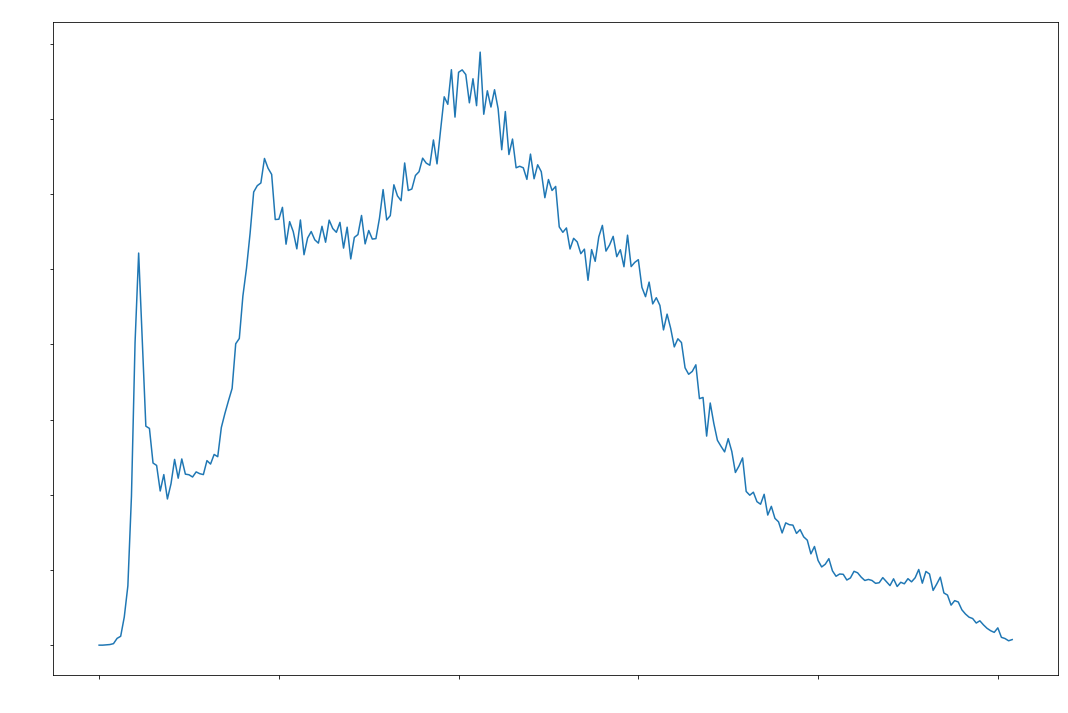

In [6]:
# Histograma de la imagen en RGB
cant, valores = np.histogram(mediana_filtrada, bins=range(2 ** 8))
fig = plt.figure(figsize=(18,12))

plt.plot(range(0, (2 ** 8) - 1), cant)
plt.xticks(color="white"),plt.yticks(color="white")
plt.title('Histograma de la imagen en RGB',color="white")
plt.xlabel('Intensidad de pixel',color="white")
plt.ylabel('Cantidad',color="white")

### K-Means (OpenCV)

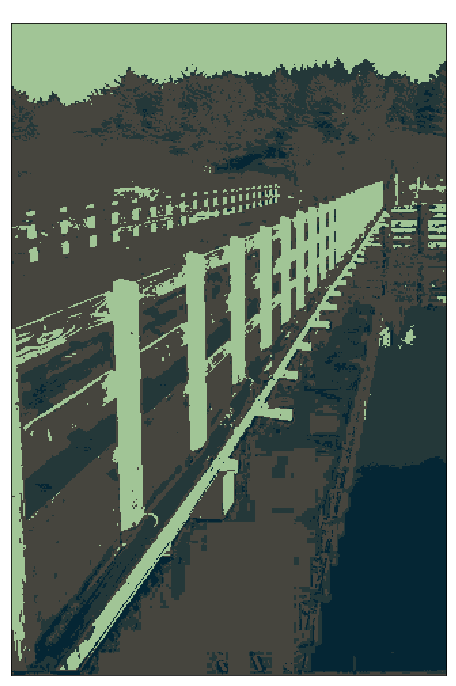

In [6]:
Z = imagen.reshape((-1,3))

# convert to np.float32
Z = np.float32(Z)

# define criteria, number of clusters(K) and apply kmeans()
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 4

ret,segmentos_kmeans,center = cv2.kmeans(Z, K, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

# Now convert back into uint8, and make original image
center = np.uint8(center)
res = center[segmentos_kmeans.flatten()]
res2 = res.reshape((imagen.shape))

res2_rgb = cv2.cvtColor(res2,cv2.COLOR_HSV2RGB)
fig = plt.figure(figsize=(18,12))
plt.imshow(res2_rgb)
plt.title('Algoritmo K-Means (OpenCV) de la imagen', color="white")
plt.xticks([]),plt.yticks([])
plt.show()


### Algoritmo SLIC (Simple Linear Iterative Clustering)

Text(0.5,1,'Algoritmo SLIC')

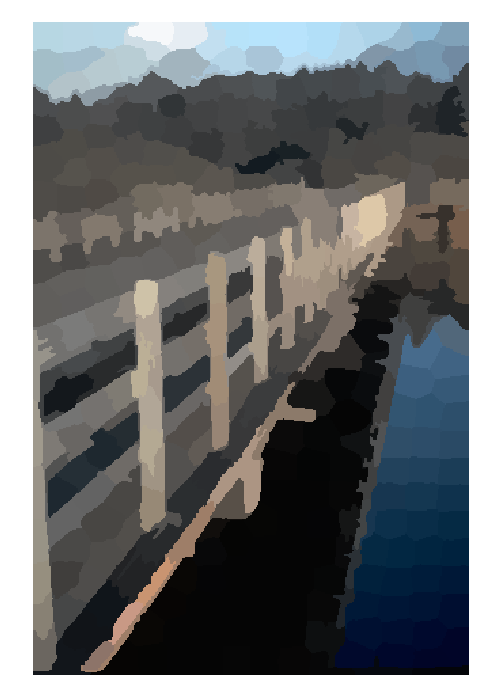

In [7]:
segmentos_slic = seg.slic(mediana_filtrada,n_segments=400, compactness=10, sigma=1)
######## CON 155 segmentos el RAG QUEDABA MAL, con 400 quedo casi impecable

# label2rgb replaces each discrete label with the average interior color
fig = plt.figure(figsize=(18,12))
plt.imshow(color.label2rgb(segmentos_slic, mediana_filtrada, kind='avg'))
plt.axis('off')
plt.title('Algoritmo SLIC', color='white')

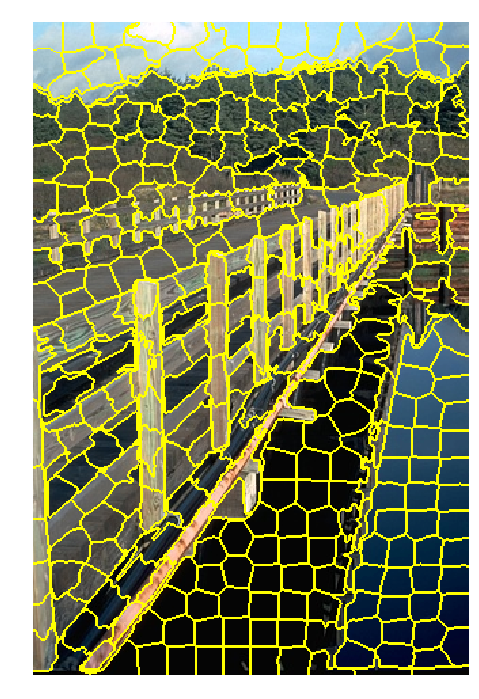

In [8]:
fig = plt.figure(figsize=(18,12))
plt.imshow(seg.mark_boundaries(imagen_rgb, segmentos_slic))
plt.axis('off')
plt.title('Contornos para Algoritmo Slic', color='white')
plt.show()

### RAG para SLIC con corte por umbral (cut threshold)

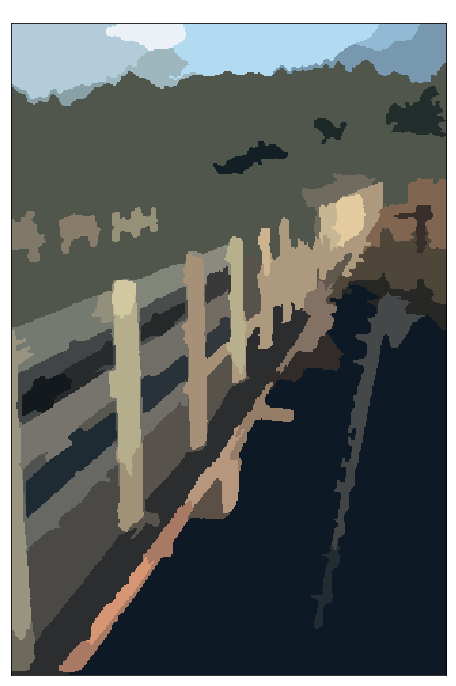

In [15]:
g = future.graph.rag_mean_color(imagen_rgb, segmentos_slic)
segmentos_rag_slic = future.graph.cut_threshold(segmentos_slic, g, 29)
out2 = color.label2rgb(segmentos_rag_slic, imagen_rgb, kind='avg')

fig = plt.figure(figsize=(18,12))
plt.imshow(out2)
plt.title('RAG para Algoritmo SLIC con corte por umbral', color="white")
plt.xticks([]),plt.yticks([])
plt.show()


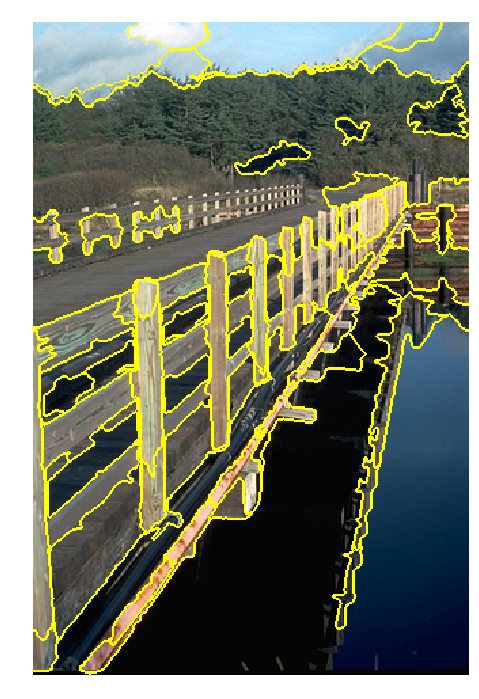

In [16]:
fig = plt.figure(figsize=(18,12))
plt.imshow(seg.mark_boundaries(imagen_rgb, segmentos_rag_slic))
plt.axis('off')
plt.title('Contornos RAG para Slic con corte por umbral', color='white')
plt.show()

### RAG para SLIC con corte normalizado (normalized cut)

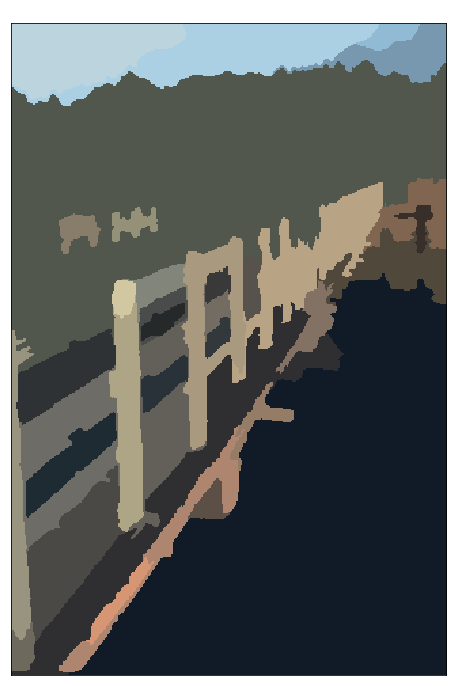

In [17]:
g = future.graph.rag_mean_color(imagen_rgb, segmentos_slic, mode='similarity')
segmentos_rag_slic_normalizado = future.graph.cut_normalized(segmentos_slic, g)
out2 = color.label2rgb(segmentos_rag_slic_normalizado, imagen_rgb, kind='avg')

fig = plt.figure(figsize=(18,12))
plt.imshow(out2)
plt.title('RAG para Algoritmo SLIC por corte normalizado', color="white")
plt.xticks([]),plt.yticks([])
plt.show()


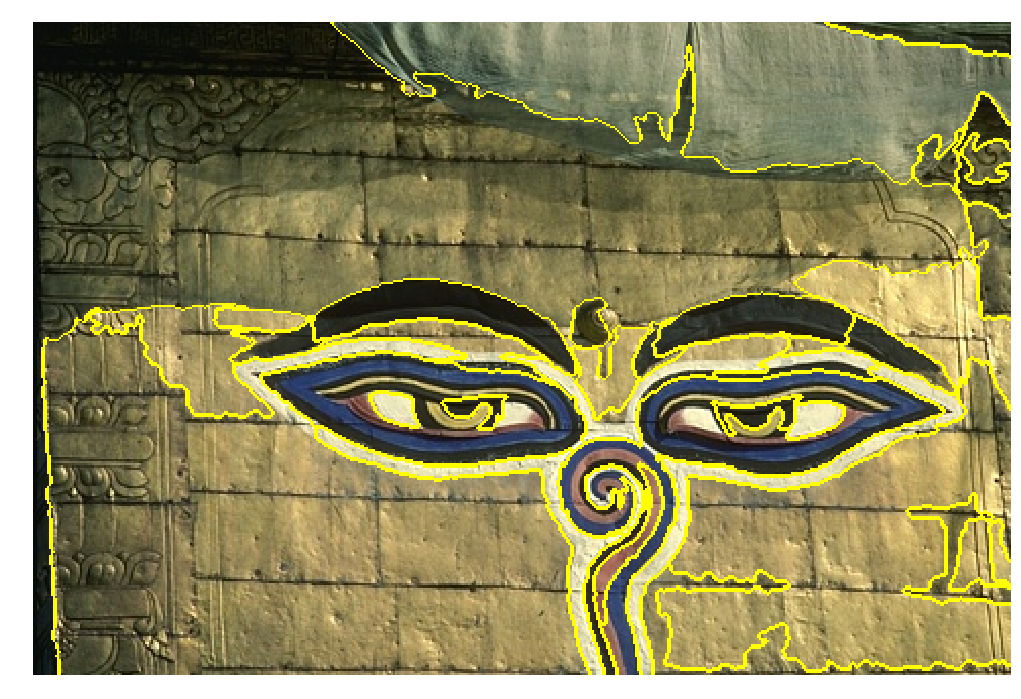

In [13]:
fig = plt.figure(figsize=(18,12))
plt.imshow(seg.mark_boundaries(imagen_rgb, segmentos_rag_slic_normalizado))
plt.axis('off')
plt.title('Contornos RAG para Slic con corte normalizado', color='white')
plt.show()

### RAG para SLIC con Merge

In [14]:
## Funciones auxiliares para RAG con Merge
def _weight_mean_color(graph, src, dst, n):
    """Callback to handle merging nodes by recomputing mean color.

    The method expects that the mean color of `dst` is already computed.

    Parameters
    ----------
    graph : RAG
        The graph under consideration.
    src, dst : int
        The vertices in `graph` to be merged.
    n : int
        A neighbor of `src` or `dst` or both.

    Returns
    -------
    data : dict
        A dictionary with the `"weight"` attribute set as the absolute
        difference of the mean color between node `dst` and `n`.
    """

    diff = graph.node[dst]['mean color'] - graph.node[n]['mean color']
    diff = np.linalg.norm(diff)
    return {'weight': diff}


def merge_mean_color(graph, src, dst):
    """Callback called before merging two nodes of a mean color distance graph.

    This method computes the mean color of `dst`.

    Parameters
    ----------
    graph : RAG
        The graph under consideration.
    src, dst : int
        The vertices in `graph` to be merged.
    """
    graph.node[dst]['total color'] += graph.node[src]['total color']
    graph.node[dst]['pixel count'] += graph.node[src]['pixel count']
    graph.node[dst]['mean color'] = (graph.node[dst]['total color'] /
                                     graph.node[dst]['pixel count'])
    

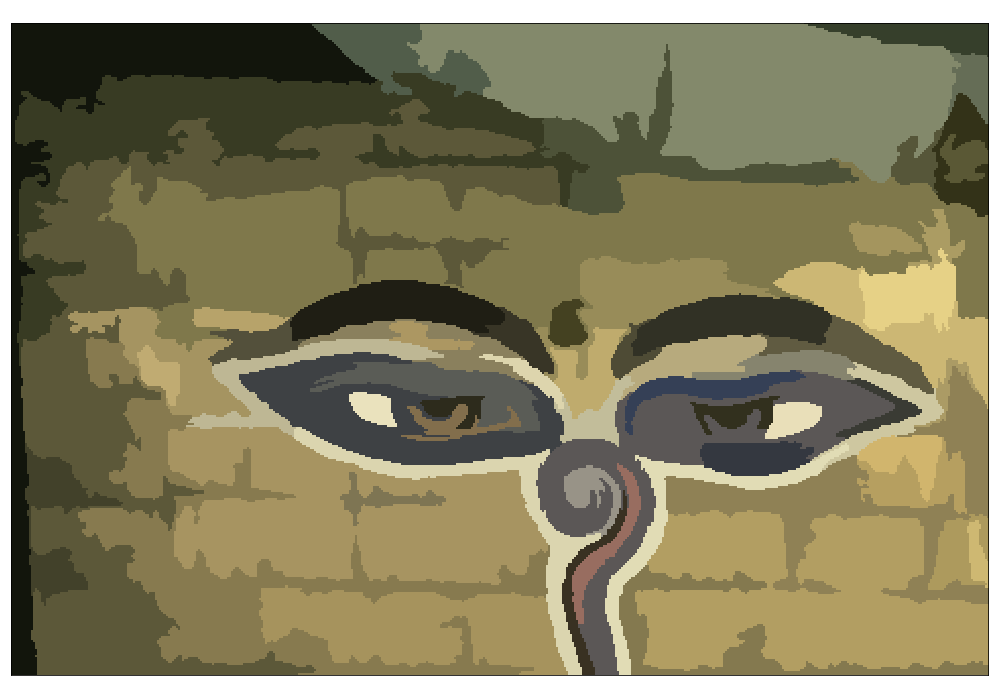

In [15]:
## RAG con Merge
g = future.graph.rag_mean_color(imagen_rgb, segmentos_slic)
segmentos_slic_merge = future.graph.merge_hierarchical(segmentos_slic, g, thresh=35, rag_copy=False,
                                   in_place_merge=True,
                                   merge_func=merge_mean_color,
                                   weight_func=_weight_mean_color)

out2 = color.label2rgb(segmentos_slic_merge, imagen_rgb, kind='avg')
fig = plt.figure(figsize=(18,12))
plt.imshow(out2)
plt.title('RAG para Algoritmo SLIC por corte normalizado', color="white")
plt.xticks([]),plt.yticks([])
plt.show()



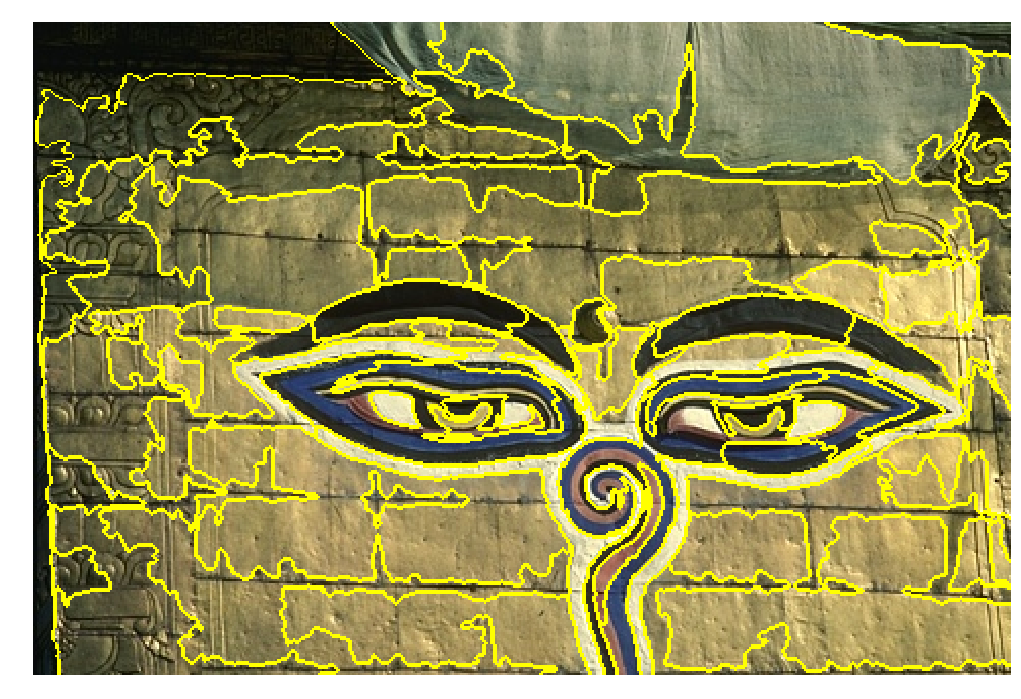

In [16]:
out2 = seg.mark_boundaries(imagen_rgb, segmentos_slic_merge, (1, 1, 0))
fig = plt.figure(figsize=(18,12))
plt.imshow(out2)
plt.axis('off')
plt.title('Contornos RAG para SLIC con Merge', color='white')
plt.show()

### Método Felzenszwalb

Metodo Felzenszwalg: 442
Metodo Felzenszwalg: 327
Metodo Felzenszwalg: 272
Metodo Felzenszwalg: 272


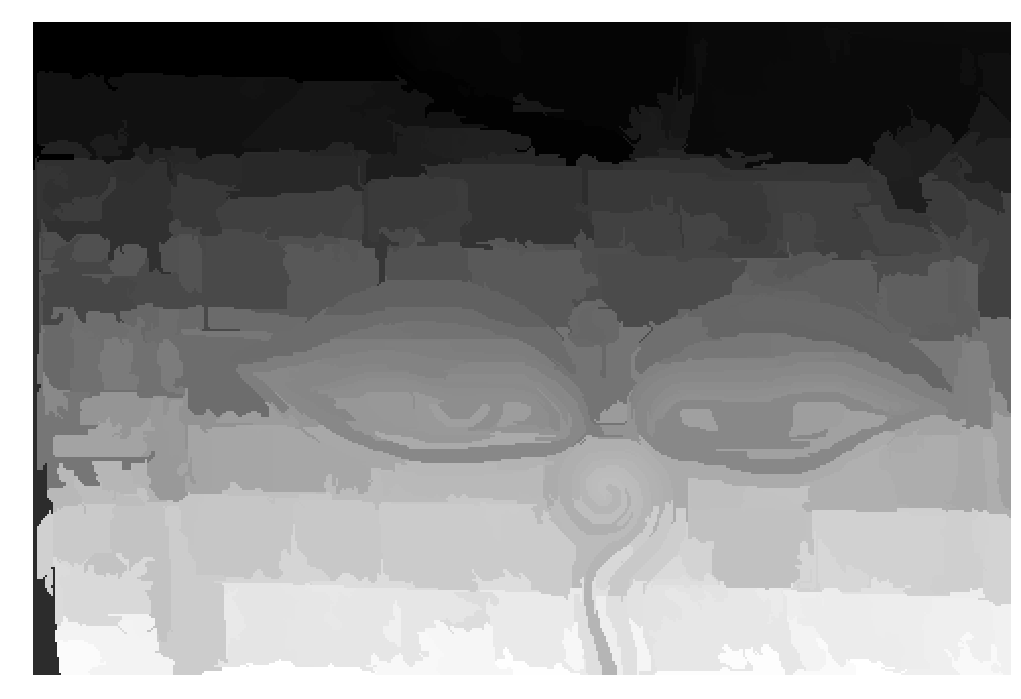

In [17]:
MAX_SEGMENTOS_FELZENSZWALB = 300
ESCALA_FELZENSZWALB = 100
SIGMA_FELZENSZWALB = 0.5
TAMANIO_MIN_FELZENSZWALB = 50
UMBRAL_CORTE_FELZENSZWALB = 29
UMBRAL_MERGE_FELZENSZWALB = 35

segmentos_felzenszwalb = seg.felzenszwalb(mediana_filtrada, scale=ESCALA_FELZENSZWALB, sigma=SIGMA_FELZENSZWALB, min_size=TAMANIO_MIN_FELZENSZWALB) 
MIN_SIZE = TAMANIO_MIN_FELZENSZWALB
print("Metodo Felzenszwalg: {}".format(np.unique(segmentos_felzenszwalb).size))
while(np.unique(segmentos_felzenszwalb).size >= MAX_SEGMENTOS_FELZENSZWALB):
    MIN_SIZE=MIN_SIZE+25
    segmentos_felzenszwalb = seg.felzenszwalb(mediana_filtrada, scale=ESCALA_FELZENSZWALB, sigma=SIGMA_FELZENSZWALB, min_size=MIN_SIZE) 
    print("Metodo Felzenszwalg: {}".format(np.unique(segmentos_felzenszwalb).size))

fig = plt.figure(figsize=(18,12))
plt.imshow(segmentos_felzenszwalb, cmap='gray')
plt.axis('off')
plt.title('Metodo Felzenszwalb', color='white')

print("Metodo Felzenszwalg: {}".format(np.unique(segmentos_felzenszwalb).size))

Text(0.5,1,'Imagen Felzenszwalb Coloreada')

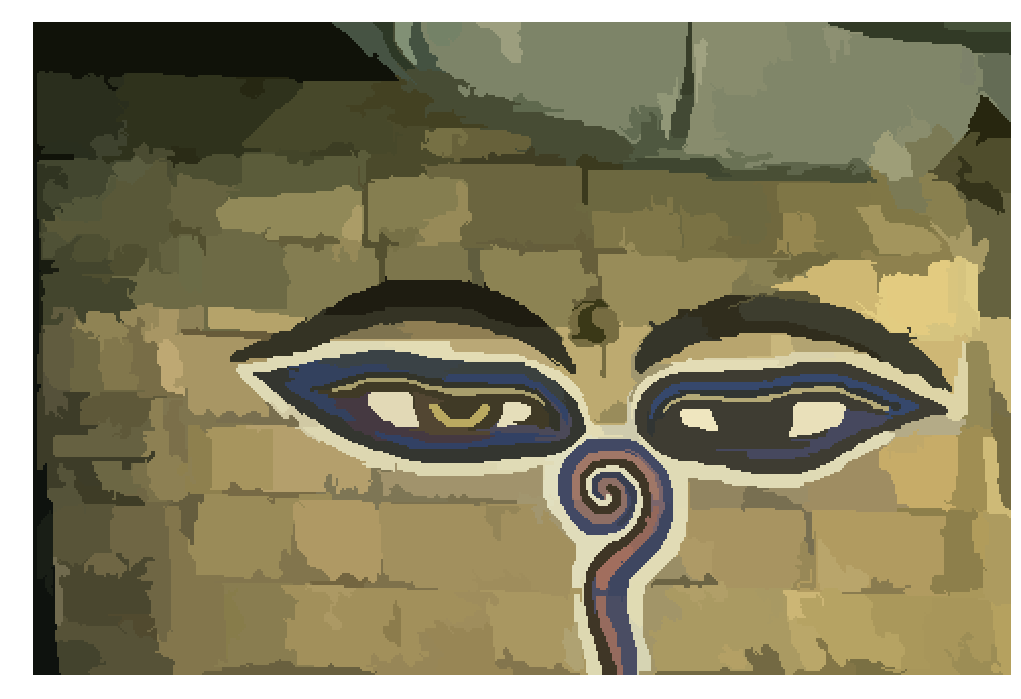

In [18]:
imagen_felzenszwalb_coloreada = color.label2rgb(segmentos_felzenszwalb, imagen_rgb, kind='avg')
fig = plt.figure(figsize=(18,12))
plt.imshow(imagen_felzenszwalb_coloreada)
plt.axis('off')
plt.title('Imagen Felzenszwalb Coloreada', color='white')

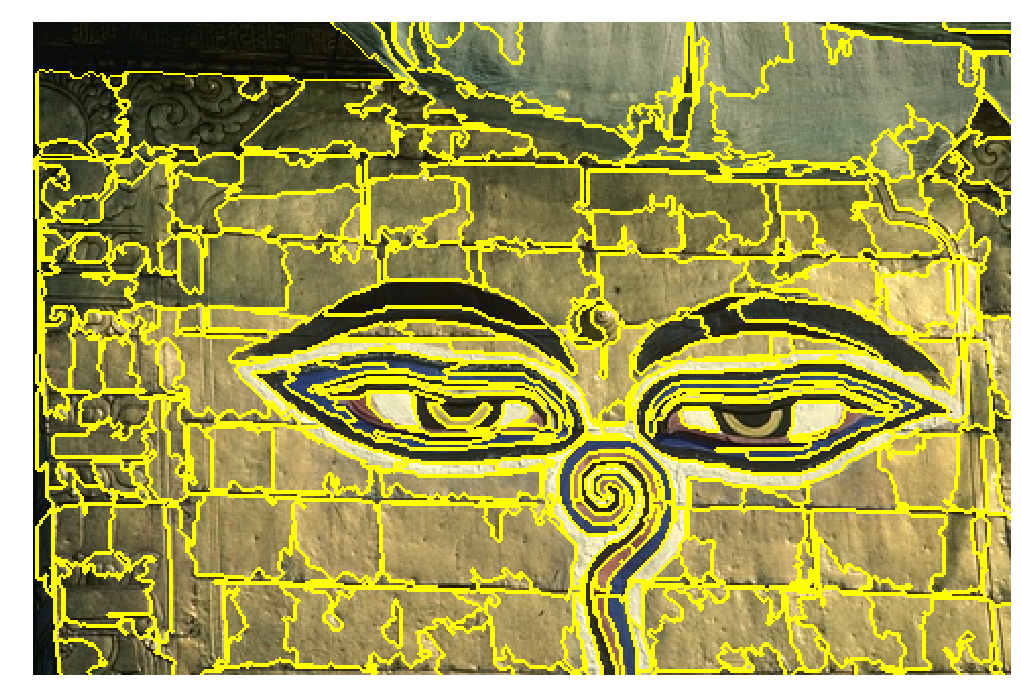

In [19]:
fig = plt.figure(figsize=(18,12))
plt.imshow(seg.mark_boundaries(imagen_rgb, segmentos_felzenszwalb,
                               color=(1, 1, 0), outline_color=None,
                               mode='outer', background_label=0))
plt.axis('off')
plt.title('Contornos para Algoritmo Felzenszwalb', color='white')

plt.show()

### RAG para Falzenszwalb con corte por umbral

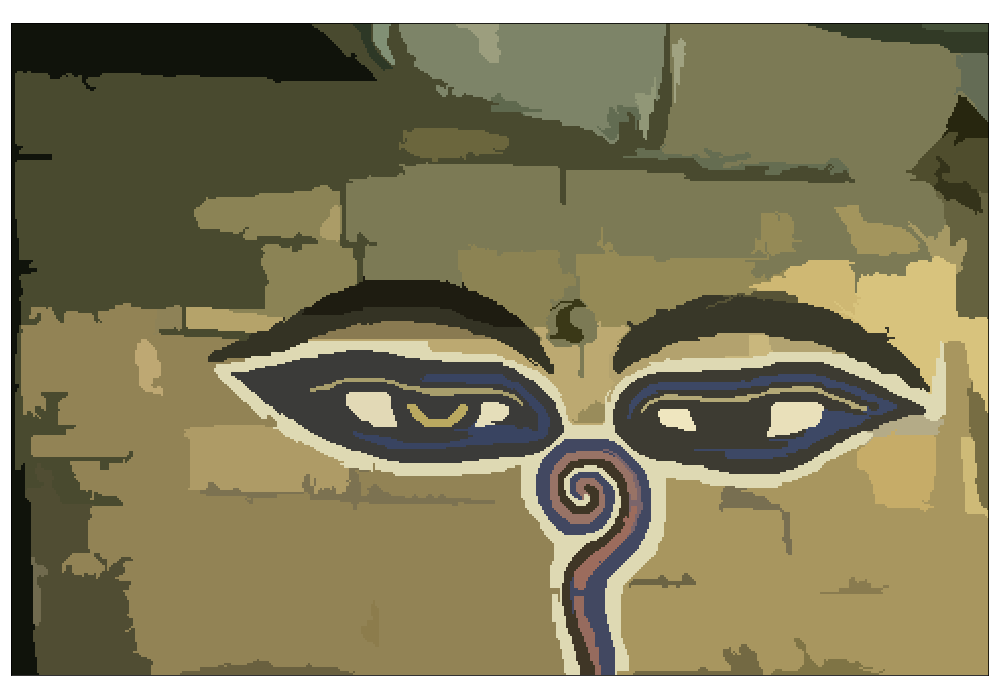

In [20]:
g = future.graph.rag_mean_color(imagen_rgb, segmentos_felzenszwalb)
segmentos_rag_felzenszwalb = future.graph.cut_threshold(segmentos_felzenszwalb, g, 29)
out2 = color.label2rgb(segmentos_rag_felzenszwalb, imagen_rgb, kind='avg')

fig = plt.figure(figsize=(18,12))
plt.imshow(out2)
plt.title('RAG para Algoritmo Felzenszwalb con corte por umbral', color="white")
plt.xticks([]),plt.yticks([])
plt.show()

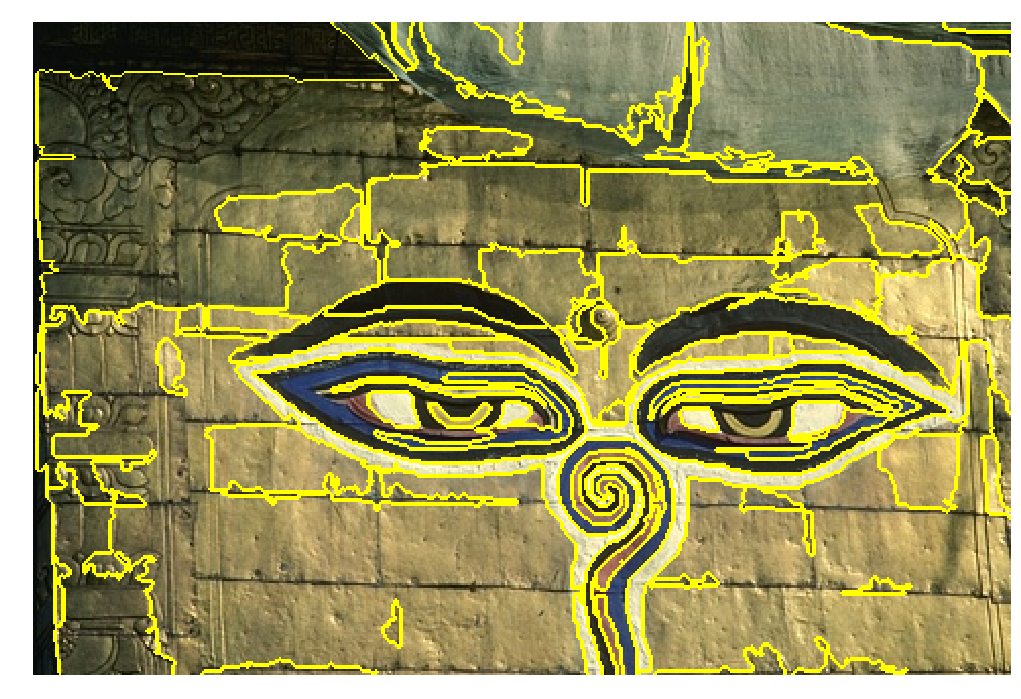

In [21]:
fig = plt.figure(figsize=(18,12))
plt.imshow(seg.mark_boundaries(imagen_rgb, segmentos_rag_felzenszwalb))
plt.axis('off')
plt.title('Contornos RAG para Felzenszwalb con corte por umbral', color='white')
plt.show()

### RAG para Felzenszwalb con corte normalizado

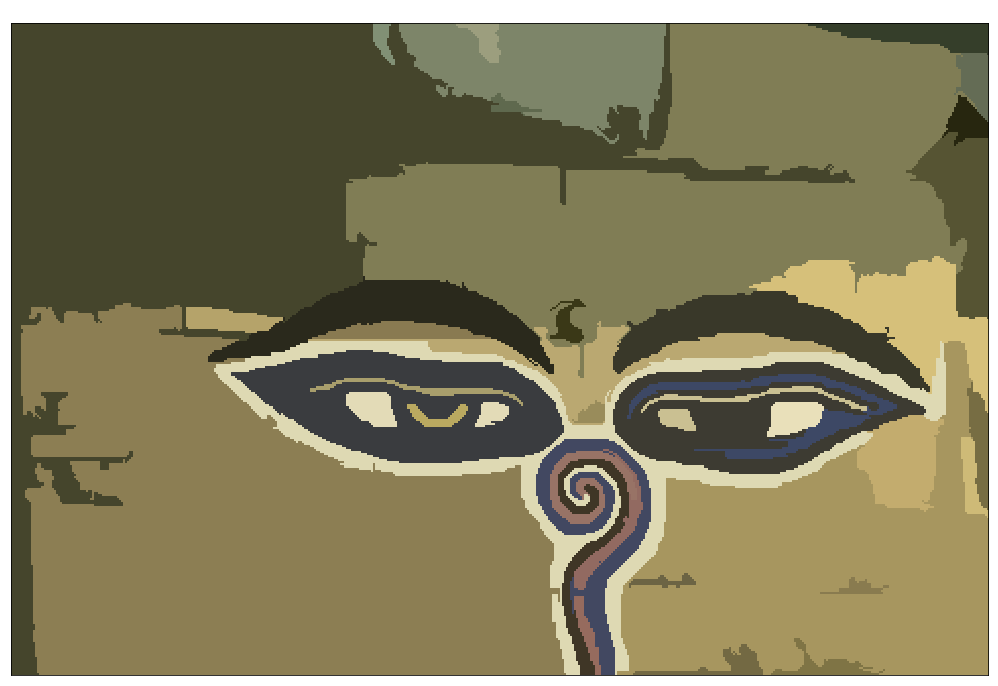

In [22]:
g = future.graph.rag_mean_color(imagen_rgb, segmentos_felzenszwalb, mode='similarity')
segmentos_rag_felzenszwalb_normalizado = future.graph.cut_normalized(segmentos_felzenszwalb, g)
out2 = color.label2rgb(segmentos_rag_felzenszwalb_normalizado, imagen_rgb, kind='avg')

fig = plt.figure(figsize=(18,12))
plt.imshow(out2)
plt.title('RAG para Algoritmo Felzenszwalb con corte normalizado', color="white")
plt.xticks([]),plt.yticks([])
plt.show()

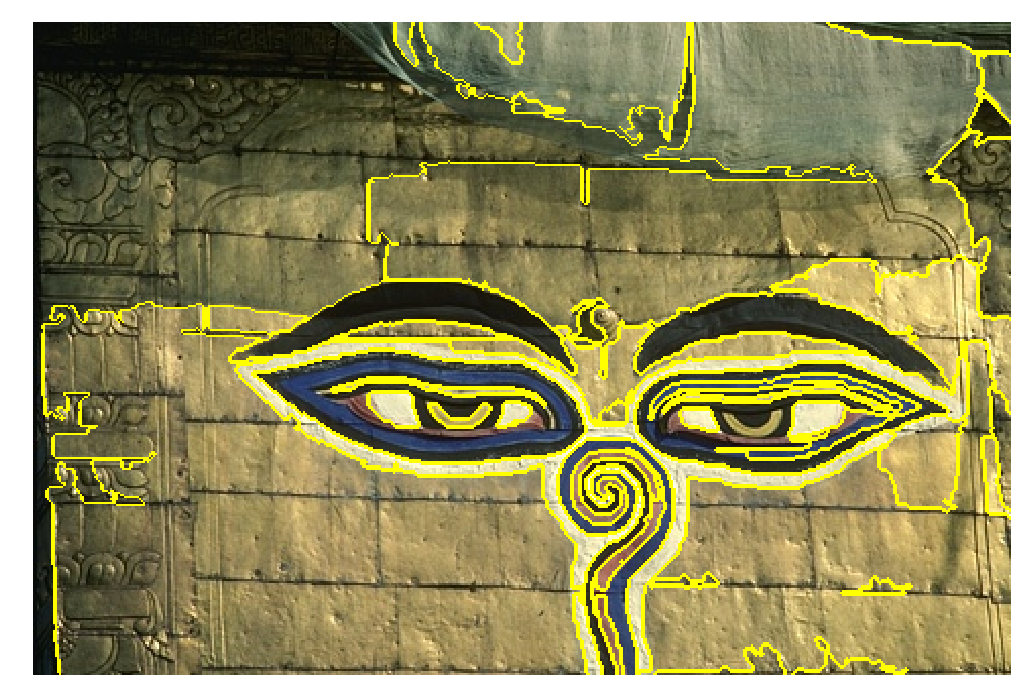

In [23]:
fig = plt.figure(figsize=(18,12))
plt.imshow(seg.mark_boundaries(imagen_rgb, segmentos_rag_felzenszwalb_normalizado))
plt.axis('off')
plt.title('Contornos RAG para Felzenszwalb con corte normalizado', color='white')
plt.show()

### RAG para Felzenszwalb con Merge

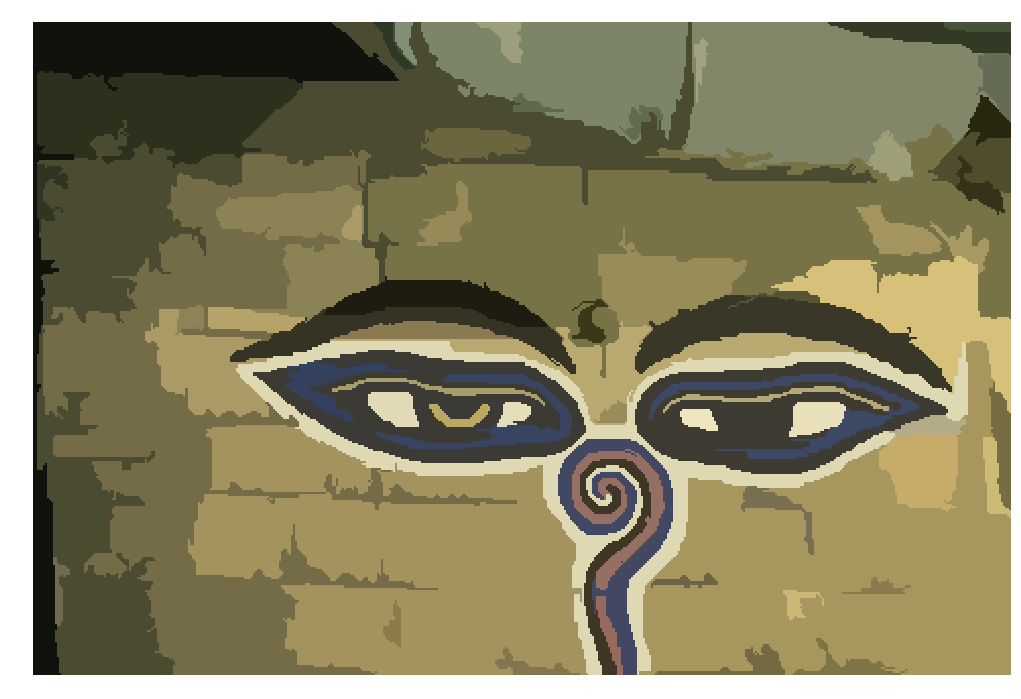

In [24]:
g = future.graph.rag_mean_color(imagen_rgb, segmentos_felzenszwalb)
segmentos_felzenszwalb_merge = future.graph.merge_hierarchical(segmentos_felzenszwalb, g,
                                                       thresh=35, rag_copy=False,
                                                       in_place_merge=True,
                                                       merge_func=merge_mean_color,
                                                       weight_func=_weight_mean_color)

imagen_felzenszwalb_mergeada = color.label2rgb(segmentos_felzenszwalb_merge, imagen_rgb, kind='avg')
fig = plt.figure(figsize=(18,12))
plt.imshow(imagen_felzenszwalb_mergeada)
plt.axis('off')
plt.title('RAG para Felzenszwalb con Merge', color='white')
plt.show()



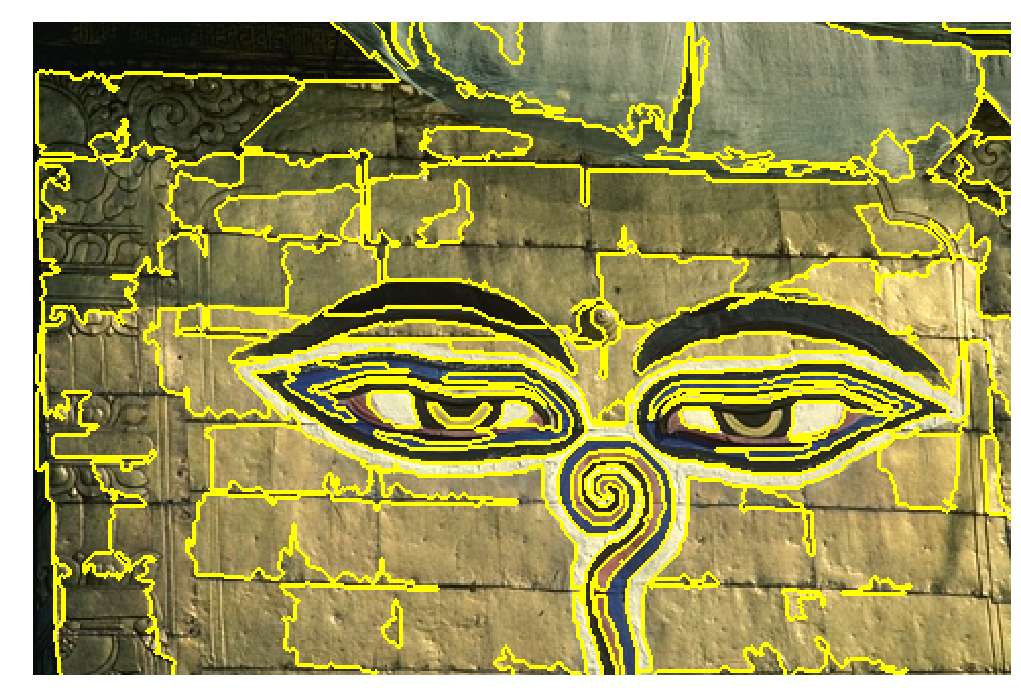

In [25]:
imagen_felzenszwalb_mergeada = seg.mark_boundaries(imagen_rgb, segmentos_felzenszwalb_merge, (1, 1, 0))
fig = plt.figure(figsize=(18,12))
plt.imshow(imagen_felzenszwalb_mergeada)
plt.axis('off')
plt.title('Contornos RAG para Felzenszwalb con Merge', color='white')
plt.show()

### Contadores de segmentos únicos segun cada algoritmo con su variante

In [26]:
print("Algoritmo K-Means (OpenCV): {}".format(np.unique(segmentos_kmeans).size))
print("Algoritmo SLIC: {}".format(np.unique(segmentos_slic).size))
print("Algoritmo Felzenszwalg: {}".format(np.unique(segmentos_felzenszwalb).size))

print("RAG SLIC con corte por umbral: {} ".format(np.unique(segmentos_rag_slic).size))
print("RAG SLIC con corte normalizado: {} ".format(np.unique(segmentos_rag_slic_normalizado).size))
print("RAG Felzenszwalb con corte por umbral: {} ".format(np.unique(segmentos_rag_felzenszwalb).size))
print("RAG Felzenszwalb con corte normalizado: {} ".format(np.unique(segmentos_rag_felzenszwalb_normalizado).size))


Algoritmo K-Means (OpenCV): 4
Algoritmo SLIC: 350
Algoritmo Felzenszwalg: 272
RAG SLIC con corte por umbral: 71 
RAG SLIC con corte normalizado: 36 
RAG Felzenszwalb con corte por umbral: 77 
RAG Felzenszwalb con corte normalizado: 41 


### Histograma de gradientes orientados

e:\utn\pes\env_py2.7\lib\site-packages\skimage\feature\_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)


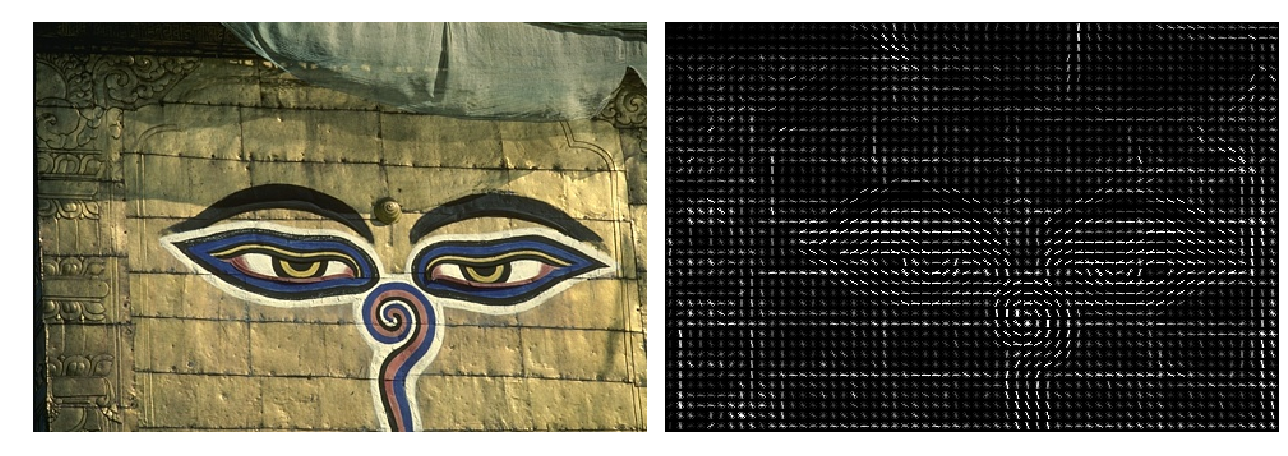

In [27]:
fd, hog_imagen = feature.hog(imagen_rgb, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(1, 1), visualize=True, multichannel=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 12), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(imagen_rgb, cmap=plt.cm.gray)
ax1.set_title('Imagen original', color='white')

# Se reescala el histograma para mejor visualizacicón
hog_imagen_rescalada = exposure.rescale_intensity(hog_imagen, in_range=(0, 40))

ax2.axis('off')
ax2.imshow(hog_imagen_rescalada, cmap=plt.cm.gray)
ax2.set_title('Histograma de Gradientes Orientados', color='white')
plt.tight_layout()
plt.show()



### Entropía

ValueError: The parameter `image` must be a 2-dimensional array

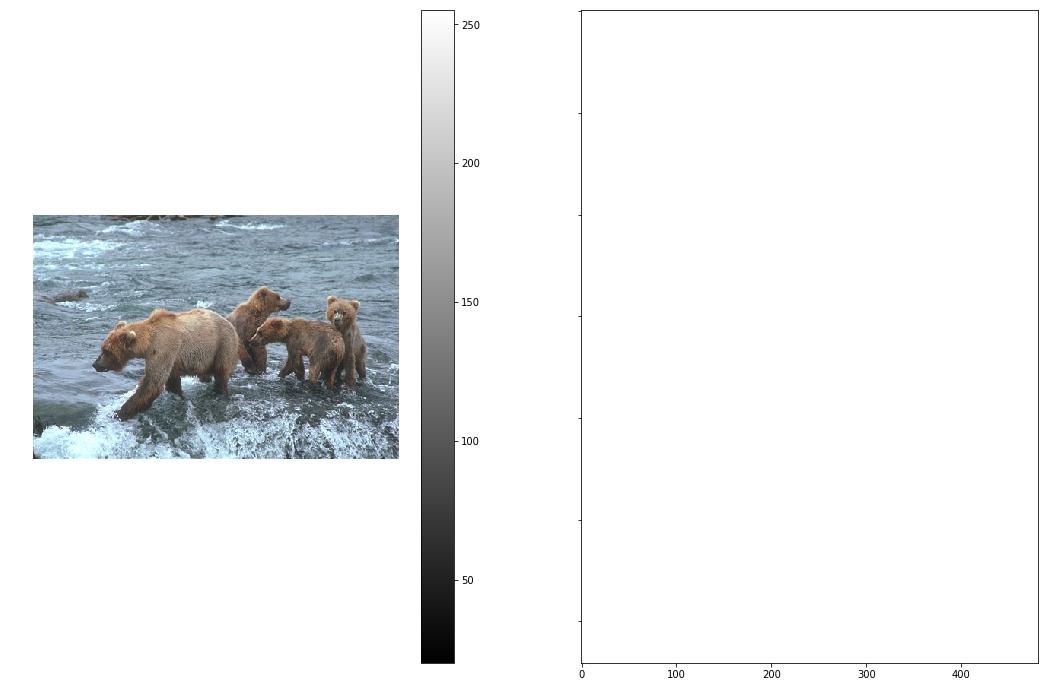

In [26]:
imagen_ubyte = util.img_as_ubyte(imagen_rgb)
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(18, 12),
                               sharex=True, sharey=True)

img0 = ax0.imshow(imagen_ubyte, cmap=plt.cm.gray)
ax0.set_title("Image", color='white')
ax0.axis("off")
fig.colorbar(img0, ax=ax0)

img1 = ax1.imshow(filters.rank.entropy(imagen_ubyte, morph.disk(5)), cmap='gray')
ax1.set_title("Entropy", color='white')
ax1.axis("off")
fig.colorbar(img1, ax=ax1)

plt.show()

### Etiquetado de contornos en base a segmentación realizada (Labeling)

In [39]:
colores = {
    '0': [0, 160, 160],
    '1': [10, 160, 160],
    '2': [20, 160, 160],
    '3': [30, 160, 160],
    '4': [40, 160, 160],
    '5': [50, 160, 160],
    '6': [60, 160, 160],
    '7': [70, 160, 160],
    '8': [80, 160, 160],
    '9': [90, 160, 160],
    '10': [100, 160, 160],
    '11': [110, 160, 160],
    '12': [120, 160, 160],
    '13': [130, 160, 160],
    '14': [140, 160, 160],
    '15': [150, 160, 160],
    '16': [160, 160, 160],
    '17': [170, 160, 160],
    '18': [180, 160, 160],
    '19': [0, 200, 200],
    '20': [10, 200, 200],
    '21': [20, 200, 200],
    '22': [30, 200, 200],
    '23': [40, 200, 200],
    '24': [50, 200, 200],
    '25': [60, 200, 200],
    '26': [70, 200, 200],
    '27': [80, 200, 200],
    '28': [90, 200, 200],
    '29': [100, 200, 200],
    '30': [110, 200, 200],
    '31': [120, 200, 200],
    '32': [130, 200, 200],
    '33': [140, 200, 200],
    '34': [150, 200, 200],
    '35': [160, 200, 200],
    '36': [170, 200, 200],
    '37': [180, 200, 200],
    '38': [0, 240, 240],
    '39': [10, 240, 240],
}

# Se obtienen los segmentos para graficar
segmentos = np.empty((
    np.unique(segmentos_rag_slic_normalizado).size,
    len(segmentos_rag_slic_normalizado),
    len(segmentos_rag_slic_normalizado[0]),
    3), np.uint8)
flag = 1
try:
    segmentos_alcanzados = np.unique(segmentos_rag_slic_normalizado)
    for a in range(len(segmentos_rag_slic_normalizado)):
        for b in range(len(segmentos_rag_slic_normalizado[0])):
            indice = np.where(
                segmentos_alcanzados == segmentos_rag_slic_normalizado[a][b]
            )[0][0]
            segmentos[indice][a][b] = colores.get(
                str(segmentos_rag_slic_normalizado[a][b]), [150,240,240])
except Exception as e:
    print("{} error: {}".format(a,e))
    


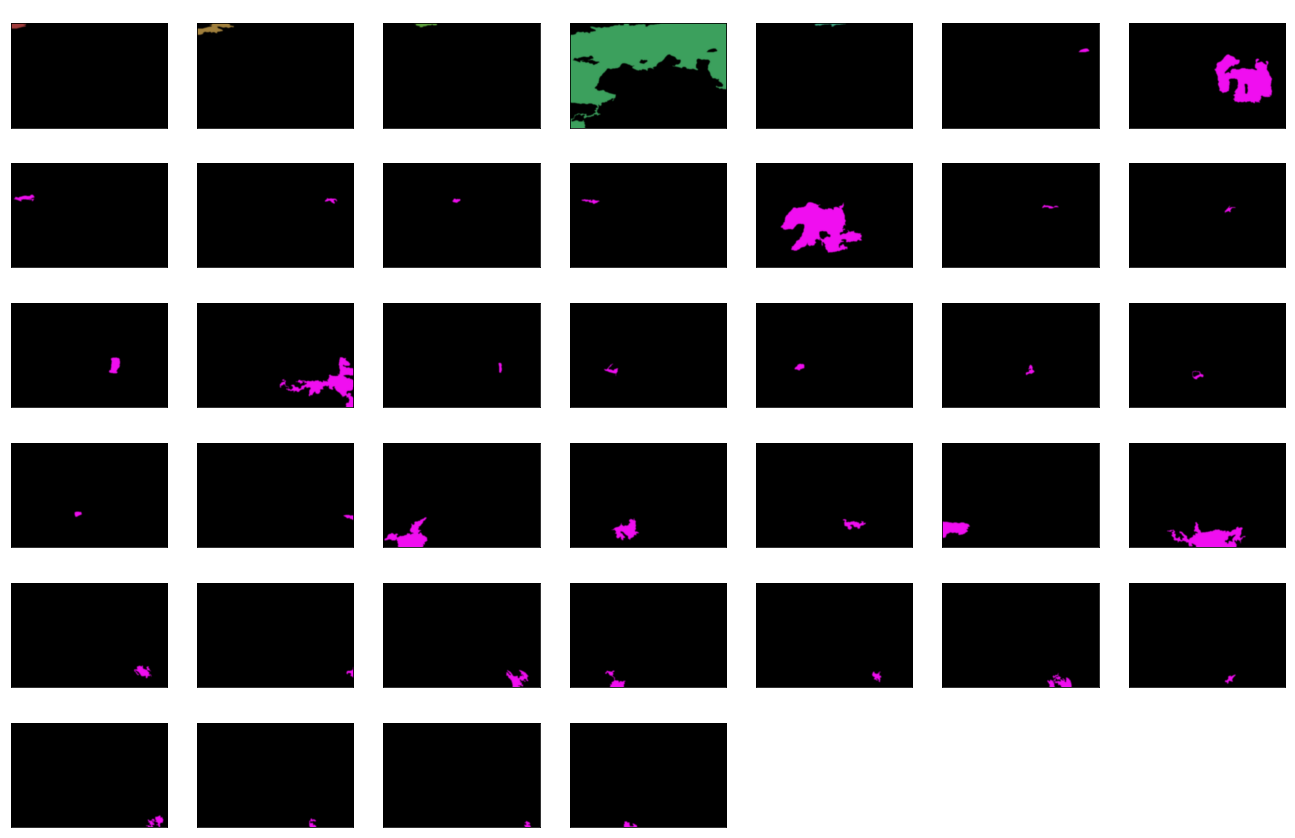

In [40]:
# Se grafican todos los segmentos
fig = plt.figure(figsize=(18,12))
imagen_segmentos = np.zeros((
    np.unique(segmentos_rag_slic_normalizado).size,
    len(segmentos_rag_slic_normalizado),
    len(segmentos_rag_slic_normalizado[0]),
    3), np.uint8)
for a in range(len(segmentos)):
    imagen_segmentos[a] = cv2.cvtColor(segmentos[a], cv2.COLOR_HSV2RGB)
    plt.subplot(6,7,a+1),plt.imshow(imagen_segmentos[a], interpolation = 'bicubic')
    plt.subplots_adjust(wspace=0.05)
    plt.tight_layout()
    plt.title("Seg {}".format(a),color="white")
    plt.xticks([]),plt.yticks([])

plt.show()

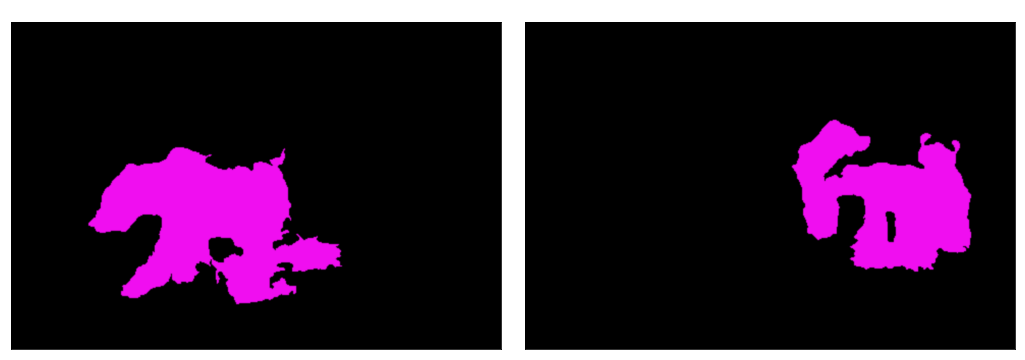

In [29]:
# Se limita a graficar los segmentos deseados (11 y 6)
fig = plt.figure(figsize=(18,12))
imagen_segmentos = np.zeros((
    np.unique(segmentos_rag_slic_normalizado).size,
    len(segmentos_rag_slic_normalizado),
    len(segmentos_rag_slic_normalizado[0]),
    3), np.uint8)
oso1 = cv2.cvtColor(segmentos[11], cv2.COLOR_HSV2RGB)
plt.subplot(1,2,1),plt.imshow(oso1, interpolation = 'bicubic')
plt.title("Oso 1",color="white")
plt.xticks([]),plt.yticks([])

oso2 = cv2.cvtColor(segmentos[6], cv2.COLOR_HSV2RGB)
plt.subplot(1,2,2),plt.imshow(oso2, interpolation = 'bicubic')
plt.title("Oso 2",color="white")
plt.xticks([]),plt.yticks([])

plt.subplots_adjust(wspace=0.05)
plt.show()

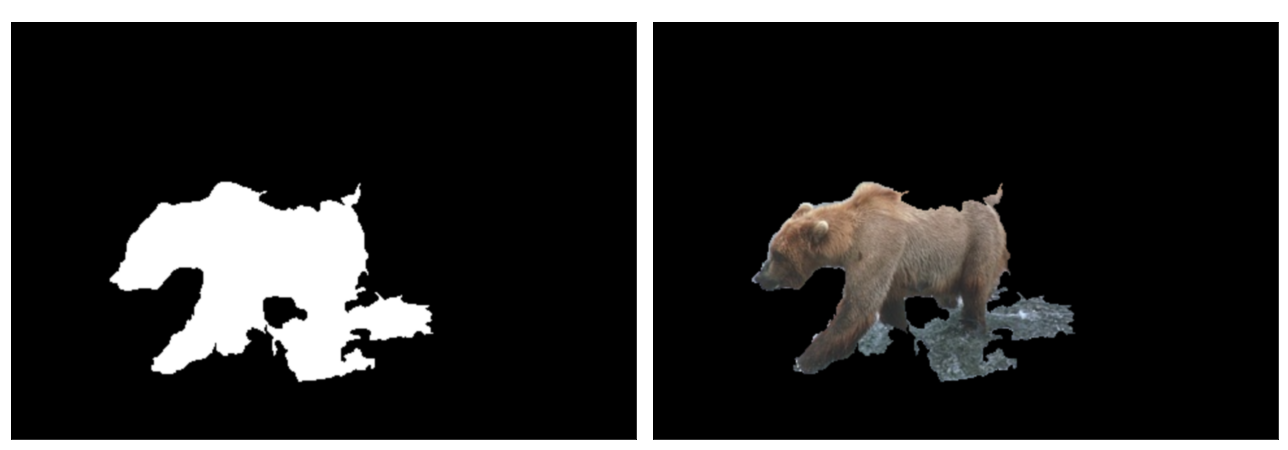

In [47]:
# Se va a graficar el oso del segmento 11 (Oso 1)

# Se aplica un threshold para convertir a escala de grises el segmento correspondiente
mascara_oso_1 = cv2.inRange(
    segmentos[11],
    np.array([50,150,150]),
    np.array([180,240,240])
)

# AND a nivel de bit para quedarme con el oso de la imagen
oso_1 = cv2.bitwise_and(imagen, imagen, mask=mascara_oso_1)

# El cv2.inRange devuelve un GRAY y no un HSV, por eso el pasaje
mascara_oso_1_rgb = cv2.cvtColor(mascara_oso_1, cv2.COLOR_GRAY2RGB)
fig = plt.figure(figsize=(18,12))

plt.subplot(1,2,1),plt.imshow(mascara_oso_1_rgb, interpolation = 'bicubic')
plt.title("Mascara Oso 1", color="white")
plt.xticks([]),plt.yticks([])

oso1_rgb = cv2.cvtColor(oso_1, cv2.COLOR_HSV2RGB)
plt.subplot(1,2,2),plt.imshow(oso1_rgb, interpolation = 'bicubic')
plt.title("Oso 1",color="white")
plt.xticks([]),plt.yticks([])

plt.subplots_adjust(wspace=0.05)
plt.tight_layout()
plt.show()

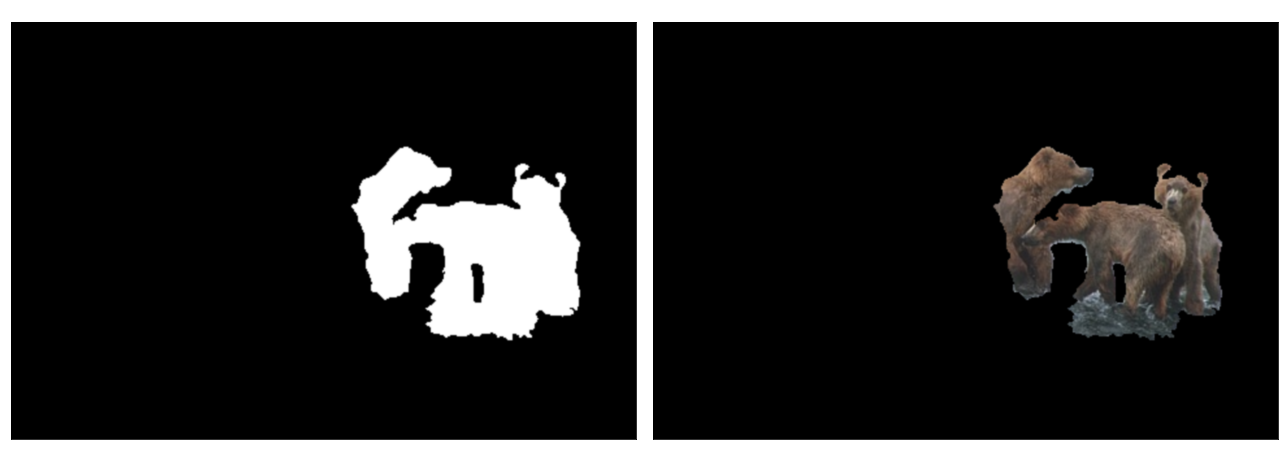

In [48]:
# Se va a graficar el oso del segmento 6 (Oso 2)

# Se aplica un threshold para convertir a escala de grises el segmento correspondiente
mascara_oso_2 = cv2.inRange(
    segmentos[6],
    np.array([50,150,150]),
    np.array([180,240,240])
)

# AND a nivel de bit para quedarme con el oso de la imagen
oso_2 = cv2.bitwise_and(imagen, imagen, mask=mascara_oso_2)

# El cv2.inRange devuelve un GRAY y no un HSV, por eso el pasaje
mascara_oso_2_rgb = cv2.cvtColor(mascara_oso_2, cv2.COLOR_GRAY2RGB)
fig = plt.figure(figsize=(18,12))

plt.subplot(1,2,1),plt.imshow(mascara_oso_2_rgb, interpolation = 'bicubic')
plt.title("Mascara Oso 2", color="white")
plt.xticks([]),plt.yticks([])

oso2_rgb = cv2.cvtColor(oso_2, cv2.COLOR_HSV2RGB)
plt.subplot(1,2,2),plt.imshow(oso2_rgb, interpolation = 'bicubic')
plt.title("Oso 2",color="white")
plt.xticks([]),plt.yticks([])
plt.subplots_adjust(wspace=0.05)
plt.tight_layout()
plt.show()

## Comparación con Ground Truth

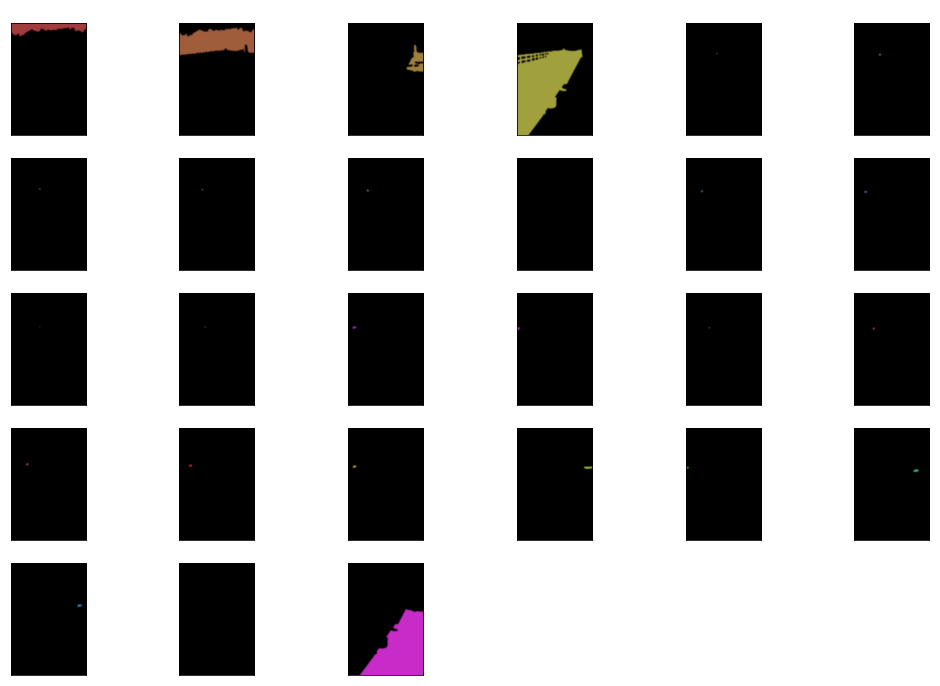

In [14]:
# Se compara con el .segment del ground truth
# el mismo se compone de una segmentacion humana

# Lectura del encabezado
estado = 0
header = 1
debug = 1
vector_img = []
segmento_img = []
fila_img = []
columna_img = []
with open(
    'ground-truth/22013-1108.seg'
    ) as fseg_humano:
    for linea in fseg_humano:
        linea = linea.replace('\n','')
        a = linea.split(' ')
        if header == 1:
            if (a[0] == 'width'):
                largo_img = int(a[1])
            if (a[0] == 'height'):
                alto_img = int(a[1])
            if (a[0] == 'segments'):
                segs_img = int(a[1])
            if (a[0] == 'data'):
                #segmentos = np.empty((segs_img, largo_img, alto_img), np.uint16)
                header = 0
        else:
            # lectura de los segmentos
            vector_img.append([[int(a[0]), int(a[1]), c] for c in np.arange(
                    int(a[2]),
                    int(a[3])
                    )])
            # 
            for c in np.arange(int(a[2]),int(a[3])):
                segmento_img.append(int(a[0]))
                fila_img.append(int(a[1]))
                columna_img.append(c)

colores = {
    '0': [0, 160, 160],
    '1': [10, 160, 160],
    '2': [20, 160, 160],
    '3': [30, 160, 160],
    '4': [40, 160, 160],
    '5': [50, 160, 160],
    '6': [60, 160, 160],
    '7': [70, 160, 160],
    '8': [80, 160, 160],
    '9': [90, 160, 160],
    '10': [100, 160, 160],
    '11': [110, 160, 160],
    '12': [120, 160, 160],
    '13': [130, 160, 160],
    '14': [140, 160, 160],
    '15': [150, 160, 160],
    '16': [160, 160, 160],
    '17': [170, 160, 160],
    '18': [180, 160, 160],
    '19': [0, 200, 200],
    '20': [20, 200, 200],
    '21': [40, 200, 200],
    '22': [60, 200, 200],
    '23': [80, 200, 200],
    '24': [100, 200, 200]
}

# Se obtienen los segmentos para graficar
img_segmentada = np.zeros((alto_img,largo_img,3), np.uint8)
segmentos_gt_humano = np.zeros((alto_img,largo_img), np.uint8)
try:
    for a in vector_img:
        for b in a:
            img_segmentada[b[1],b[2]] = colores.get(str(b[0]), [150,200,200])
            segmentos_gt_humano[b[1]][b[2]] = str(b[0])
except Exception as e:
    print("{} error: {}".format(a,e))

# Se arma las mascaras para cada uno de los segmentos
segmentos_humano = np.zeros((segs_img,alto_img,largo_img,3), np.uint8)
try:
    for a in vector_img:
        for b in a:
            segmentos_humano[b[0]][b[1],b[2]] = colores.get(str(b[0]), [150,200,200])
except Exception as e:
    print("{} error: {}".format(a,e))

# Se grafican los segmentos
fig = plt.figure(figsize=(18,12))
imagen_segmentos_humano = np.zeros((segs_img,alto_img,largo_img,3), np.uint8)
for a in range(len(segmentos_humano)):
    imagen_segmentos_humano[a] = cv2.cvtColor(segmentos_humano[a], cv2.COLOR_HSV2RGB)
    plt.subplot(5,6,a+1),plt.imshow(imagen_segmentos_humano[a], interpolation = 'bicubic')
    plt.subplots_adjust(wspace=0.05)
    plt.title("Seg {}".format(a),color="white")
    plt.xticks([]),plt.yticks([])

plt.show()

In [ ]:
# BORRADOR
# Voy a generar una tabla que refleje en sus filas los segmentos calculados
# y en sus columnas los segmentos ground-truth
# el valor dentro de cada celda sera la cantidad de pixels que dichos segmentos
# comparten entre sí. Ejemplo
#        Seg1            Seg2           Seg3 Total        %Mayor     %Mayor-1
#Seg1     02             25             00    27     25/27=92,6%    2/27=7,4%
#Seg2    120             01             00   121  120/121=99,17%  1/121=0,08%
#%Mayor 120/122=98,6%  25/26=96,15%    NULL
# El número resultante del match entre segmentaciones
# resulta el promedio de los % que no son NULL
# Es decir, (0,986+0,9615)/2=0,9737 => Es una buena segmentacion
# Si, por el contrario, se tuviera esta tabla resultante:
#        Seg1            Seg2           Seg3 Total        %Mayor     %Mayor-1
#Seg1     15             12             00    27          55,5%       44,5%
#Seg2     61             60             00   121          51%         50%
#%Mayor 61/76=80%  60/72=83%    NULL

# DEFINITIVO
# Voy a generar una tabla que refleje en sus filas los segmentos calculados
# y en sus columnas los segmentos ground-truth
# Adicionalmente se generar otra tabla con los porcentajes de matcheo
# entre el segmento de la fila (calculado) y el segmento del ground-truth
#        Seg1            Seg2           Seg3     Total
#Seg1     02             25             00         27
#Seg2    120             01             00        121
#Total   122             26             00        148

#         Seg1            Seg2           Seg3
#%Seg1  2/122=0,01%    25/27=92%         NULL => es NULL porque el total es 0
#%Seg2  120/122=98%    1/27=3,7%         NULL => sino sería el % que da la cuenta

# Finalmente hay que tomar el mayor porcentaje de la tabla
# y separarlo a la vez que "cancelamos" esa fila y columna
# luego iterar el procedimiento sumando dicho % al anterior
# cancelar esa fila y esa columna
# iterar hasta que no queden filas o columnas
# finalizar realizando un promedio de dichos porcentajes
# ese número final será el identificador del
# segmento calculado para el ground-truth elegido
# debera repetirse dicho procedimiento para todos los ground-truth
# y tomar un promedio total de todos los números (promedios) de match

# opcional 1°:
# se podría realizar el mismo procedimiento pero a la inversa
# tomando los menores porcentajes de la tabla
# lo que no se es que significaría dicho número
# opcional 2°:
# se podría adicionar un número que compare la cantidad de segmentos
# pero, en ppio, dicho número casi siempre daría bajo

In [49]:
# las imagenes son de 481x321 el segmentos_rag_slic_normalizado
# es un array de arrays de 321 posiciones con 481 elementos
# cada uno cuyos valores son el segmento al que pertenece

# cree segmentos_gt_humano que tiene el mismo formato que los segmentos_rag_..

# se iterara pixel a pixel acumulando los "match" en una tabla
#      Seg20 Seg204 Seg38 SegXX
# Seg14   0
# Seg22   0
# SegYY   0
# siendo array_segs los SegYY (dicha columna no existe en la tabla solo los valores)
# y array_segs_humano los SegXX (dicha fila no existe en la tabla solo los valores)

#segmentos_a_evaluar = np.copy(segmentos_slic) #=> prom_porc: 0.25..
#segmentos_a_evaluar = np.copy(segmentos_rag_slic) #=> prom_porc: 0.34..
#segmentos_a_evaluar = np.copy(segmentos_rag_slic_normalizado) #=> prom_porc: 0.41..
#segmentos_a_evaluar = np.copy(segmentos_slic_merge) #=> prom_porc: 0.32..
#segmentos_a_evaluar = np.copy(segmentos_felzenszwalb) #=> prom_porc: 0.37
#segmentos_a_evaluar = np.copy(segmentos_rag_felzenszwalb) #=> prom_porc: 0.38
#segmentos_a_evaluar = np.copy(segmentos_rag_felzenszwalb_normalizado) #=> prom_porc: 0.34
#segmentos_a_evaluar = np.copy(segmentos_felzenszwalb_merge) #=> prom_porc: 0.3
#
# para testear la funcion
segmentos_a_evaluar = np.copy(segmentos_gt_humano) #=> prom_porc: 1.0

cant_segs = np.unique(segmentos_a_evaluar).size
cant_segs_humano = segs_img
tabla_match = np.zeros((cant_segs,cant_segs_humano), np.uint32)
array_segs_humano = []
array_segs = []
for a in range(alto_img):
    for b in range(largo_img):
        seg_aux = segmentos_a_evaluar[a][b]
        seg_aux_humano = segmentos_gt_humano[a][b]
        if (seg_aux not in array_segs):
            array_segs.append(seg_aux)
        if (seg_aux_humano not in array_segs_humano):
            array_segs_humano.append(seg_aux_humano)
        indice_aux = array_segs.index(seg_aux)
        indice_aux_humano = array_segs_humano.index(seg_aux_humano)
        
        tabla_match[indice_aux][indice_aux_humano] += 1

print("\narray_segs: \n{}".format(array_segs))
print("\narray_segs_humano: \n{}".format(array_segs_humano))
print("\ntabla_match: \n{}".format(tabla_match))

array_suma = np.zeros((cant_segs_humano), np.uint32)
for a in range(cant_segs):
    for b in range(cant_segs_humano):
        array_suma[b] += tabla_match[a][b]
        
print("\narray_suma: \n{}".format(array_suma))


array_segs: 
[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 15, 19, 20, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54, 56, 52, 57, 58, 59, 61, 62, 64, 65, 67, 68, 63, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 81, 80, 82, 84, 85, 86, 89, 88, 90, 91, 92, 93, 95, 96, 97, 98, 99, 100, 102]

array_segs_humano: 
[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 15, 19, 20, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54, 56, 52, 57, 58, 59, 61, 62, 64, 65, 67, 68, 63, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 81, 80, 82, 84, 85, 86, 89, 88, 90, 91, 92, 93, 95, 96, 97, 98, 99, 100, 102]

tabla_match: 
[[ 8332     0     0 ...     0     0     0]
 [    0 19741     0 ...     0     0     0]
 [    0     0  6096 ...     0     0     0]
 ...
 [    0     0     0 ...     0     0     0]
 [    0     0     0 ...     0     0     0]
 [    

In [50]:
# Se arma la tabla con porcentajes
tabla_porc = np.zeros((cant_segs,cant_segs_humano), np.float32)
for a in range(cant_segs):
    for b in range(cant_segs_humano):
        if (array_suma[b] == 0):
            tabla_porc[a][b] = None
        else:
            tabla_porc[a][b] = tabla_match[a][b]/array_suma[b]

print("\ntabla_porc: \n{}".format(tabla_porc))


tabla_porc: 
[[ 1.  0.  0. ... nan nan nan]
 [ 0.  1.  0. ... nan nan nan]
 [ 0.  0.  1. ... nan nan nan]
 ...
 [ 0.  0.  0. ... nan nan nan]
 [ 0.  0.  0. ... nan nan nan]
 [ 0.  0.  0. ... nan nan nan]]


In [51]:
# Se calculan los mayores porcentajes excluyendo los elegidos y se los promedia
sum_porc = 0
prom_porc = 0
maximo = 0
indice_max = -1
indices_tomados = []
for b in range(cant_segs_humano):
    if (np.isnan(tabla_porc[0][b])):
        continue
    for a in range(cant_segs):
        if (a not in indices_tomados):
            if (tabla_porc[a][b] > maximo):
                maximo = tabla_porc[a][b]
                indice_max = a
                #print("maximo: {}".format(maximo))
    sum_porc += maximo
    #print("suma: {}".format(sum_porc))
    indices_tomados.append(indice_max)
    maximo = 0
    indice_max = -1

prom_porc = sum_porc / len(indices_tomados)
print("\nsum_porc: \n{}".format(sum_porc))
print("\nlen(indices_tomados): \n{}".format(len(indices_tomados)))
print("\nprom_porc: \n{}".format(prom_porc))



sum_porc: 
92.0

len(indices_tomados): 
92

prom_porc: 
1.0


### Hierarchical merging on region boundary Region Adjacency Graphs (RAGs)

True

In [44]:
MAX_SEGMENTOS_FELZENSZWALB = 300
ESCALA_FELZENSZWALB = 100
SIGMA_FELZENSZWALB = 0.5
TAMANIO_MIN_FELZENSZWALB = 50
UMBRAL_CORTE_FELZENSZWALB = 29
UMBRAL_MERGE_FELZENSZWALB = 35

segmentos_felzenszwalb = seg.felzenszwalb(mediana_filtrada, scale=ESCALA_FELZENSZWALB, sigma=SIGMA_FELZENSZWALB, min_size=TAMANIO_MIN_FELZENSZWALB) 
MIN_SIZE = TAMANIO_MIN_FELZENSZWALB
print("Metodo Felzenszwalg: {}".format(np.unique(segmentos_felzenszwalb).size))
while(np.unique(segmentos_felzenszwalb).size >= MAX_SEGMENTOS_FELZENSZWALB):
    MIN_SIZE=MIN_SIZE+25
    segmentos_felzenszwalb = seg.felzenszwalb(mediana_filtrada, scale=ESCALA_FELZENSZWALB, sigma=SIGMA_FELZENSZWALB, min_size=MIN_SIZE) 
    print("Metodo Felzenszwalg: {}".format(np.unique(segmentos_felzenszwalb).size))


Metodo Felzenszwalg: 777
Metodo Felzenszwalg: 548
Metodo Felzenszwalg: 415
Metodo Felzenszwalg: 352
Metodo Felzenszwalg: 299
